# Décrire l'emplacement du soleil

Pour décrire l'emplacement du soleil, deux systèmes de coordonnées semblent très pratique: le système de coordonnées **horizontales**, qui pose un repère local; et le système de coordonnées **équatoriales**, qui se place dans un repère héliocentrée.

## Azimuth et Elevation - Horizontale

```{sidebar} Note
D'autres bases orthonormées directes sont possibles, comme par exemple Ox orienté à l'ouest et Oy au sud. L'azimuth est alors négatif le matin, entre autres. La définition de l'azimuth est également variable, se méfier.
```

On se place dans un repère (0,x,y,z) orthonormé direct, avec x pointant vers l'est, y vers le nord et z à la verticale. Notons $\vec{s}$ le vecteur solaire, càd un vecteur de norme 1 pointant vers le soleil.


Comme le soleil se déplace à distance fixe (plus ou moins) de la Terre, il ne se déplace qu'en deux dimensions sur la "sphère céleste. Il est donc possible de décrire sa position avec deux angles,  il est possible de décrire sa position avec 2 angles: l'azimuth et l'élévation. 

![dessin](../images/Dessin.PNG)

Plus d'informations: [Wikipédia](https://fr.wikipedia.org/wiki/Syst%C3%A8me_de_coordonn%C3%A9es_horizontales)

### Azimuth - $\alpha$

![North Azimuth](../images/azimElevCelestial.PNG)

Cet angle correspond à la direction du soleil dans le plan horizontale; 0° correspond au Nord, 90° à l'est, etc.

On peut le définir comme l'angle entre
1. Le projeté du vecteur solaire $\vec{s}$ dans le plan (0,x,y)
2. Le vecteur dirigé au nord ($\vec{Oy}$)

### Elevation - $\gamma$

![Elevation](../images/elev.PNG)

L'élevation ($\gamma$) est l'angle formé entre le soleil et la ligne de l'horizon.

### Vecteur solaire

Le vecteur solaire est un vecteur pointant vers le soleil. Dans cette base et pour cette définition de l'azimuth, il s'exprime comme:

$$
\vec{s}= \sin(\alpha) \times \cos(\gamma) \vec{u_x} + \cos(\alpha) \times \cos(\gamma) \vec{u_y} + \sin(\gamma) \vec{u_z}
$$

**Démonstration:** Cela peut se démontrer en utilisant deux matrices de rotation: 
1. Une première matrice  $P_{B_0}^{B_1}$ correspondant à une matrice de rotation d'un angle $-\alpha$ autour de l'axe z
2. Une deuxième matrice de rotation $P_{B_1}^{B_2}$ correspondant à une matrice de rotation d'un angle $\gamma$ autour de l'axe x.

Ces dernières s'écrivent donc: $P_{B_0}^{B_1} = \begin{pmatrix} \cos(\alpha) & \sin(\alpha) & 0 \\ -\sin(\alpha) & \cos(\alpha) & 0 \\ 0 & 0 & 1 \end{pmatrix}$ et $P_{B_1}^{B_2} = \begin{pmatrix} 1 & 0 & 0 \\ 0 & \cos(\gamma) & -\sin(\gamma) \\ 0 & \sin(\gamma) & \cos(\gamma) \end{pmatrix}$

Dans la base $B_2$, le vecteur solaire s'écrit: $\vec{s}_{B_2} = \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}$. La formule de changement de base s'écrit: $\vec{s}_{B_0} = P_{B_0}^{B_2} . \vec{s}_{B_2}$. On trouve alors le résultat.

In [1]:
#Le code présenté ici est détaillé dans la suite; il est néanmoins pratique à copier-coller, offrant la possibilité
# de conna^tre la position du soleil en instantané ;)

from math import sin, cos, tan,asin, pi,atan2
import numpy as np
import copy as cp
import datetime

class solarVector:
    def __init__(self,x=0.,y=0.,z=1.,lat = pi/4,long = 5*pi/180):
        self.x=x
        self.y=y
        self.z=z
        self.lat=lat #latitude
        self.long = long
        self.azim=0.
        self.elev=0.
        self.declin=0
        self.hourAngle=0
        self.h=0
        self.calc()
    
    def calc(self):
        (self.azim,self.elev)=azimElevFromSolarVector(self)
        (self.declin,self.hourAngle)=declinHourFromSolarVector(self,self.lat)
        self.h = 12+self.hourAngle*180/(pi*15)
        
    def __str__(self):
        self.calc()
        rez="x--->"+str(self.x)+", y--->" +str(self.y)+", z---> "+str(self.z)+"\n"
        rez+="azimuth -> " + str(self.azim*180/pi) +"° , elevation -> "+str(self.elev*180/pi)+"° \n"
        rez+="Declination -> " + str(self.declin*180/pi) +"°, hour angle -> " +str(self.hourAngle*180/pi)+"° \n"
        return rez
        
    def npArr(self):
        return np.array([self.x,self.y,self.z])
    
    def printAzimElev(self):
        print('azimuth --->' +str(self.azim*180/pi) +"°  , elevation---> "+str(self.elev*180/pi)+"°")
        
    def printDeclinHour(self):
        print('declinaison --->' +str(self.azim*180/pi) +"°  , Angle horaire ---> "+str(self.elev*180/pi)+"°")
        
    def azimElev(self):
        self.calc()
        return (self.azim,self.elev)
    
    def setAzimElev(self,azim,elev):
        lol = solarVectorFromAzimElev(azim,elev)
        [self.x,self.y,self.z] = [lol.x,lol.y,lol.z]
        self.calc()
    
    def setDeclinHour(self,declin, hour):
        lol = solarVectorFromDeclinHour(declin,hour,self.lat)
        [self.x,self.y,self.z] = [lol.x,lol.y,lol.z]
        self.calc()
    
    def declinHour(self):
        self.calc()
        return (self.declin,self.hour)
    
    def now(self):
        dateNow = datetime.datetime.utcnow()
        lol = sunPosPSA(dateNow,self.long,self.lat)
        [self.x,self.y,self.z] = [lol.x,lol.y,lol.z]
        self.calc()

def solarVectorFromAzimElev(azim,elev):
    sx = sin(azim) * cos(elev);
    sy = cos(azim) * cos(elev);
    sz = sin(elev);
    return solarVector(sx,sy,sz);


def azimElevFromSolarVector(s):
    elev = asin(s.z);
    interm = asin(s.x / cos(elev)-0.00000000000002);
    if (s.y>0):
        if (s.x > 0):
            azim = interm;
        else:
            azim = 2 * pi + interm;
    else:
        azim = pi - interm;
    return (azim,elev)

def solarDeclinationByDayNumber(day):
    return asin(sin(-23.44*pi/180.)*cos(0.98565*pi/180*(N+1)+1.914*pi/180.*sin(0.98565*pi/180.*(N-2))))

def solarVectorFromDeclinHour(declination,hourAngle,lat):
    sx = -cos(declination) * sin(hourAngle);
    sy = sin(declination) * cos(lat) - cos(declination) * sin(lat) * cos(hourAngle);
    sz = sin(declination) * sin(lat) + cos(declination) * cos(lat) * cos(hourAngle);
    return solarVector(sx,sy,sz)

def declinHourFromSolarVector(sunvec,lat) :
    declin = asin((sunvec.y+sunvec.z * tan(lat)) / (cos(lat) + sin(lat) * tan(lat)));
    interm = -asin(sunvec.x / cos(declin));
    test = (sin(declin) * cos(lat) - sunvec.y) / (cos(declin) * sin(lat));
    if (abs(cos(interm) - test) < 0.001):
        hour = interm;
    elif (sunvec.x < 0):
        hour = pi - interm;
    else:
        hour = -pi - interm;
    return (declin,hour)

#Algorithme PSA, updaté avec les dernières valeurs de Blanco et al.
def sunPosPSA(dateUTC,  dLongitude,  dLatitude):
    [iYear, iMonth,iDay, dHours, dMinutes,  dSeconds] = [dateUTC.year,dateUTC.month,dateUTC.day,dateUTC.hour,dateUTC.minute,dateUTC.second]
    dDecimalHours = dHours + (dMinutes+ dSeconds / 60.0) / 60.0;
    # Calculate current Julian Day
    liAux1 = (iMonth - 14) / 12;
    liAux2 = (1461 * (iYear + 4800 + liAux1)) / 4 + (367 * (iMonth- 2 - 12 * liAux1)) / 12  \
        - (3 * ((iYear + 4900+ liAux1) / 100)) / 4 +iDay - 32075;
    dJulianDate = (liAux2)-0.5 + dDecimalHours / 24.0;
    # Calculate difference between current Julian Day and JD 2451545.0 
    dElapsedJulianDays = dJulianDate - 2451545.0;
    

    # Calculate ecliptic coordinates (ecliptic longitude and obliquity of the 
    # ecliptic in radians but without limiting the angle to be less than 2*Pi 
    # (i.e., the result may be greater than 2*Pi)
    
    dOmega = 2.267127827 - 9.300339267*pow(10,-4) * dElapsedJulianDays;
    dMeanLongitude = 4.895036035 + 0.01720279602 * dElapsedJulianDays; # Radians
    dMeanAnomaly = 6.239468336 + 0.01720200135 * dElapsedJulianDays;
    dEclipticLongitude = dMeanLongitude + 0.03338320972 * sin(dMeanAnomaly) \
            + 0.0003497596876 * sin(2 * dMeanAnomaly) - 0.0001544353226 \
            - 8.689729360*pow(10,-6) * sin(dOmega);
    dEclipticObliquity = 0.4090904909 - 6.213605399*pow(10,-9) * dElapsedJulianDays \
            + 4.418094944*pow(10,-5) * cos(dOmega);


    # Calculate celestial coordinates ( right ascension and declination ) in radians 
    # but without limiting the angle to be less than 2*Pi (i.e., the result may be 
    # greater than 2*Pi)
    
    dSin_EclipticLongitude = sin(dEclipticLongitude);
    dY = cos(dEclipticObliquity) * dSin_EclipticLongitude;
    dX = cos(dEclipticLongitude);
    dRightAscension = atan2(dY, dX);
    if (dRightAscension < 0.0):
        dRightAscension = dRightAscension + 2*pi;
    dDeclination = asin(sin(dEclipticObliquity) * dSin_EclipticLongitude);
    

    # Calculate solar vector
    
    dGreenwichMeanSiderealTime = 6.697096103 +0.06570984737 * dElapsedJulianDays+ dDecimalHours;
    dLocalMeanSiderealTime = (dGreenwichMeanSiderealTime * 15 * pi / 180.+ dLongitude) ;
    dHourAngle = dLocalMeanSiderealTime - dRightAscension;
    return solarVectorFromDeclinHour(dDeclination, dHourAngle, dLatitude);

In [2]:
test = solarVector()
test.now()
print(test)

x--->-0.6510847948223799, y--->-0.43449934123915335, z---> 0.6223334415037016
azimuth -> 236.28296336164982° , elevation -> 38.486735685483644° 
Declination -> 7.632508550076479°, hour angle -> 41.06423623595609° 



## Latitude, déclinaison et angle horaire - Systèmes Equatoriales

Ce repère correspond à un repère héliocentré. Néanmoins, le vecteur solaire est donné dans la base locale d'un observateur situé à la latitude $\phi$ et au temps t. Plus d'informations: [Wikipédia](https://fr.wikipedia.org/wiki/Syst%C3%A8me_de_coordonn%C3%A9es_%C3%A9quatoriales)

![Déclinaison](../images/declinaison.PNG)

### Déclinaison

La déclinaison ($\delta$) correspond à l'inclinaison de l'axe de la terre. Ce dernier varie de -23.4° au solstice d'hiver à 23.4° au solstice d'été. Cet angle peut être relié au jour de l'année via de nombreuses corrélations, la plus reconnue étant celle de l'algorithme PSA.
En voici une très proche.

In [3]:
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=False)
init_notebook_mode(connected=False)

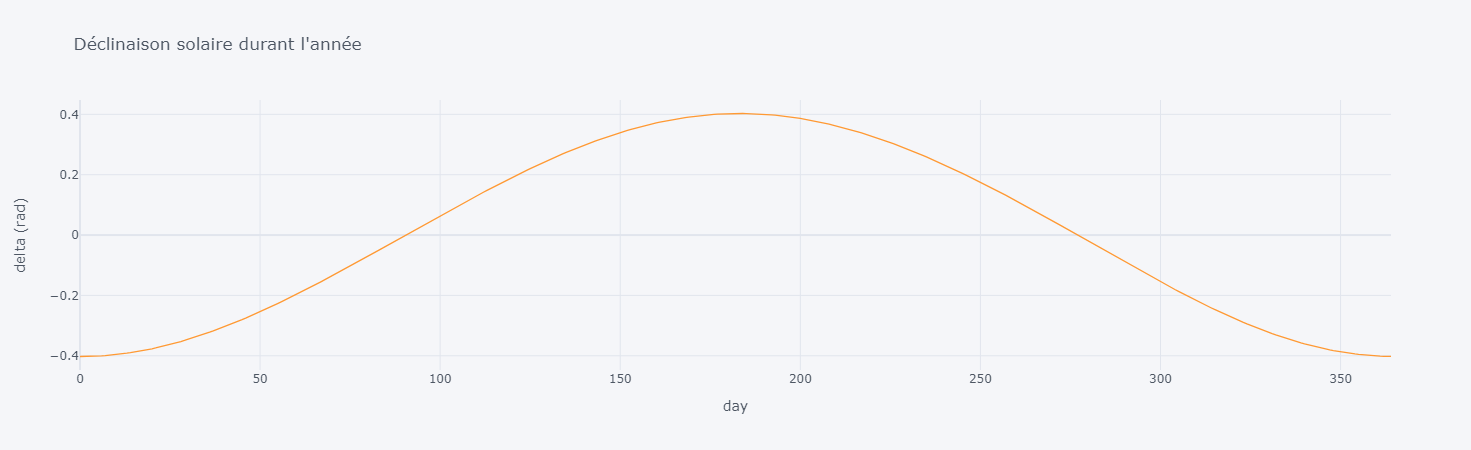

In [4]:
from math import cos, sin
def solarDeclinationByDayNumber(day):
    Pi = 3.14159;
    omega = (2 * Pi) / 365 * (day - 1.);
    return 0.006918 - 0.399912 * cos(omega) - 0.006758 * cos(2 * omega) + 0.000907 * sin(2 * omega) - 0.002697 * cos(3 * omega) + 0.00148 * sin(3 * omega);

xDays=[k for k in range(0,365)]
deltaDays=[solarDeclinationByDayNumber(k) for k in range(0,365)]
dfYear=pd.DataFrame([xDays,deltaDays]).T
dfYear.columns=["day","declination"]
dfYear.iplot(kind='scatter',x="day",y="declination", title="Déclinaison solaire durant l'année", xTitle="day", yTitle=" delta (rad)")

### Angle horaire

L'angle horaire ($\omega$) est défini par la rotation de la Terre par rapport au midi heure solaire. Il vaut 0 à midi, est positif dans l'après-midi et négatif le matin.

La terre faisant 360° en 24 heures, la Terre décrit $\frac{360 ° }{24h}=15°/h$. Ce qui peut s'écrire $\frac{d \omega}{dt}=15°/h$ avec *t* le temps en heure. D'où, après intégration : $\omega = (t-12)*15 °= \frac{\pi}{180} \times 15 \times (t-12) \ rad $

Dans cette équation, le temps est en UTC ou heure solaire. En France, (pour l'instant?), l'heure d'été est UTC+2 et hiver UTC+1, c'est-à-dire qu'en hiver le soleil est au sud à 13h et en été à 14h.

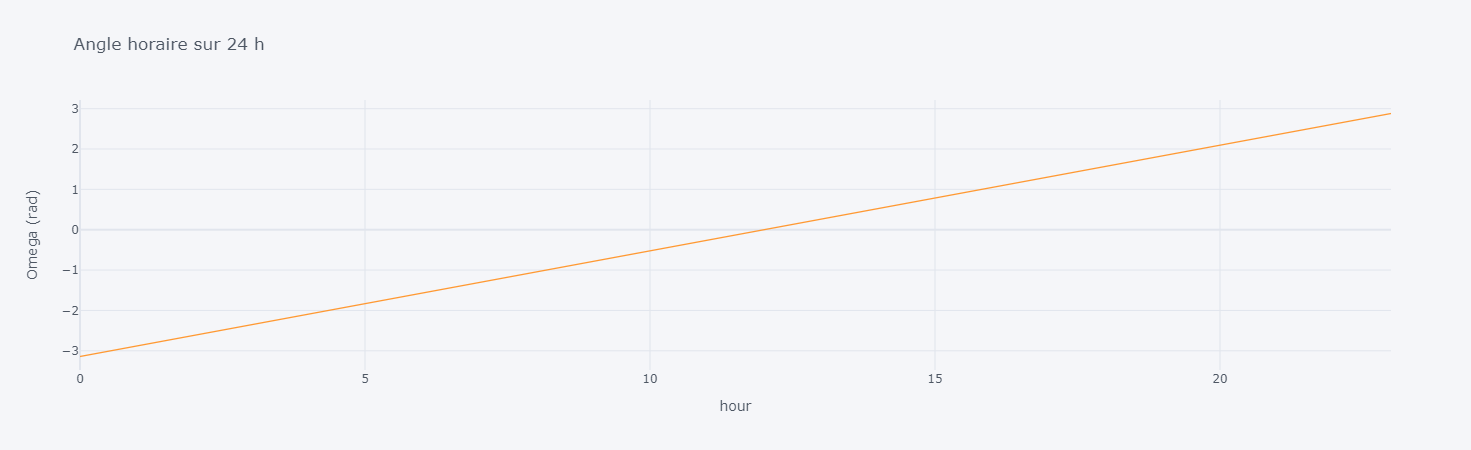

In [9]:
from math import pi
dfDay=pd.DataFrame(data= [[k for k in range(0,24)],[(k-12)*15*pi/180 for k in range(0,24)]]).T
dfDay.columns = ["hour","omega"]
dfDay.iplot(x='hour',y='omega', title = "Angle horaire sur 24 h", xTitle="hour", yTitle="Omega (rad)")

L'heure maximale $\omega_{max}$, càd l'heure à laquelle le soleil se couche, s'écrit $\omega_{max} = \arccos(-\tan(\phi) \times \tan(\delta) )$

In [10]:
from math import acos, tan, pi
def omegaMax(day,lat):
    return acos(-tan(lat)*tan(solarDeclinationByDayNumber(day)))

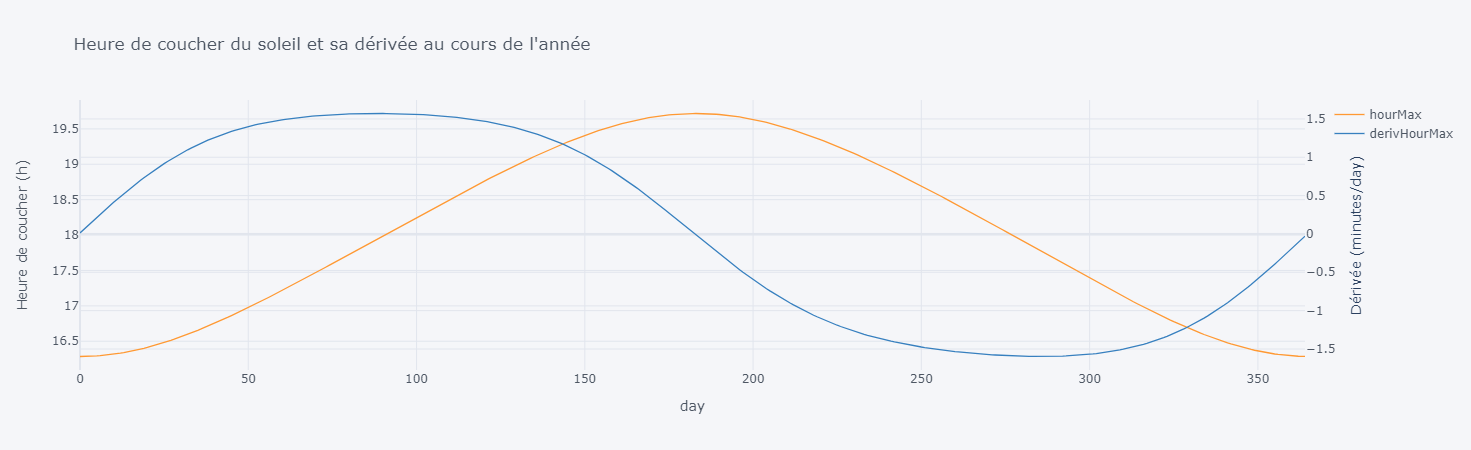

In [11]:
phi=45.564601 * 3.14159/180;
dfYear['omega_max']=[omegaMax(k,phi) for k in range(0,365)]
dfYear['derivHourMax']=[(omegaMax(k+1,phi)-omegaMax(k,phi))*180/(3.14159*15)*60 for k in range(0,365)]
dfYear['hourMax']=[12+dfYear['omega_max'][k]*180/(3.14159*15) for k in range(0,365)]
dfYear.iplot(x="day",y="hourMax",secondary_y="derivHourMax",
             title="Heure de coucher du soleil et sa dérivée au cours de l'année",
            xTitle="day", yTitle="Heure de coucher (h)", secondary_y_title="Dérivée (minutes/day)")

### Vecteur solaire

Idée de démonstrations: produit de matrices de rotation pour arriver sur le bon repère: Base 0 -> Géocentrée, avec un axe vers le soleil et un z sur la moyenne de l'axe terrestre

Le vecteur solaire dans la base locale à l'observateur s'écrit alors:

$$
\vec{s} = - \cos(\delta) \times \sin(\omega) \vec{u_x}\\
+ (\sin(\delta) \times \cos(\phi) - \cos(\delta) \times \cos(\omega) \times \sin(\phi) ) \times \vec{u_y}\\
+ (\sin(\delta) \times \sin(\phi) + \cos(\delta) \times \cos(\omega) \times \cos(\phi) ) \times \vec{u_z}
$$

In [12]:
def solarVectorFromDeclinHour(declination,hourAngle,lat):
    sx = -cos(declination) * sin(hourAngle);
    sy = sin(declination) * cos(lat) - cos(declination) * sin(lat) * cos(hourAngle);
    sz = sin(declination) * sin(lat) + cos(declination) * cos(lat) * cos(hourAngle);
    return solarVector(sx,sy,sz)

## Passer d'un système de coordonnées à l'autre

L'idée est de passer d'un système à l'autre via le vecteur solaire. Les deux formules donnant le vecteur solaire dans le même repère, il devient facile de les inverser. Les algorithmes suivant ont été vérifiés mais on n'est jamais ampte de se planter..

### Du vecteur solaire à l'azimuth et l'élévation

In [13]:
from math import asin, cos, pi
def azimElevFromSolarVector(s):
    elev = asin(s.z);
    interm = asin(s.x / cos(elev)-0.00000000000002);
    if (s.y>0):
        if (s.x > 0):
            azim = interm;
        else:
            azim = 2 * pi + interm;
    else:
        azim = pi - interm;
    return (azim,elev)

### Du vecteur solaire à la déclinaison et l'angle horaire

In [18]:
from math import asin, cos, sin, tan
def declinHourFromSolarVector(s,lat):
    declin = asin((s.y + s.z * tan(lat)) / (cos(lat) + sin(lat) * tan(lat)));
    interm = -asin(s.x / cos(declin));
    test = (sin(declin) * cos(lat) - s.y) / (cos(declin) * sin(lat));
    if (abs(cos(interm) - test) < 0.001):
        hour = interm;
    elif (s.x < 0):
        hour = pi - interm;
    else:
        hour = -pi - interm;
    return(declin, hour)

### D'un système à l'autre

In [19]:
def azimElevFromDeclinHour(declin,hour,lat):
    s=solarVectorFromDeclinHour(declin,hour,lat)
    return azimElevFromSolarVector(s)

In [20]:
def declinHourFromAzimElev(azim,elev,lat):
    s=solarVectorFromAzimElev(azim,elev)
    return declinHourFromSolarVector(s,lat)


## Tracés annuels

A l'aide de la déclinaison, de l'heure et de la latitude, il nous est désormais possible de trouver l'azimuth et l'élévation. Ce système de coordonnées locales est le plus utilisé lorsqu'il s'agit de réfléchir à un système solaire.

### Azimuth et élévation

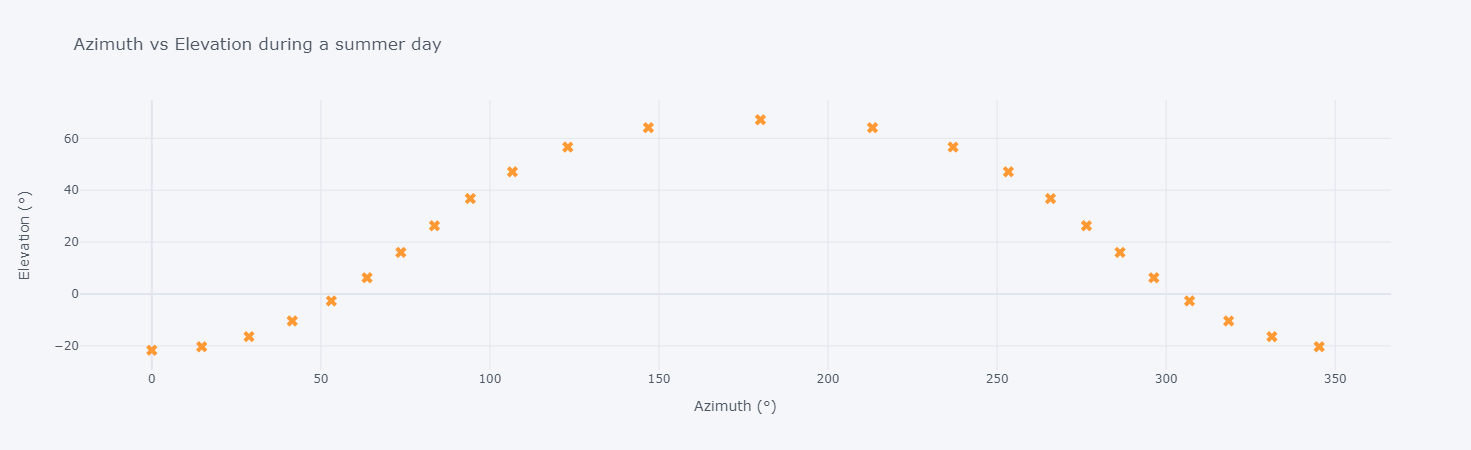

In [21]:
from math import pi
day=173
degree=pi/180;
dfDay=pd.DataFrame(data=[[k for k in range(0,24)],[(k-12)*15*pi/180 for k in range(0,24)]]).T;
declin=solarDeclinationByDayNumber(day);
hourAngleMax=omegaMax(day,phi);
dfDay.columns = ["hour","omega"];
azimElev=[azimElevFromDeclinHour(declin,dfDay['omega'][k],phi) for k in range(0,24)];
dfDay['azimuth']=[azimElev[k][0]/degree for k in range(0,24)];
dfDay['elevation']=[azimElev[k][1]/degree for k in range(0,24)];
dfDay.iplot(kind='scatter',mode='markers',size=10,symbol='x', x="azimuth", y="elevation", 
            title = "Azimuth vs Elevation during a summer day", xTitle= "Azimuth (°)", yTitle="Elevation (°)", text="hour")

In [22]:
from math import pi
def plotAzimVsElev(day):
    degree=pi/180;
    dfDay=pd.DataFrame(data=[[k for k in range(0,24)],[(k-12)*15*pi/180 for k in range(0,24)]]).T;
    declin=solarDeclinationByDayNumber(day);
    hourAngleMax=omegaMax(day,phi);
    dfDay.columns = ["hour","omega"];
    azimElev=[azimElevFromDeclinHour(declin,dfDay['omega'][k],phi) for k in range(0,24)];
    dfDay['azimuth']=[azimElev[k][0]/degree for k in range(0,24)];
    dfDay['elevation']=[azimElev[k][1]/degree for k in range(0,24)];
    dfDay.head()
    dfDay.iplot(kind='scatter',mode='markers',size=10,symbol='x', x="azimuth", y="elevation", 
            title = "Azimuth vs Elevation on day n° "+str(day), xTitle= "Azimuth (°)", yTitle="Elevation (°)", text="hour")

Lorsque l'élévation est négative, cela correspond aux heures à laquelle le soleil ne s'est pas encore levé.

In [ ]:
0.712*0.712+0.1*0.1+0.14*0.14

### Algorithme PSA: connaître la localisation du soleil 

L'algorithme développé par le PSA pour la localisation du soleil est de très bonne qualité, précis à quelques arcsecondes près. En créant un solarVector test, et en appelant test.now(), vous stockerez dans test la réelle position du soleil au moment précis où vous l'appeler. L'utilisation de print(test) vous donnera toutes les informations angulaires sur le soleil à l'instant où vous avez appelé la méthode now().

Il est intéressant également de se demander à quelle heure locale arrivera le soleil au sud. 

## Bonus: Algorithme pour la position de la lune

In [ ]:
def JulianDay (date, month, year, UT)
{

if (month<=2):
    month=month+12;
    year=year-1;
return (int)(365.25*year) + (int)(30.6001*(month+1)) - 15 + 1720996.5 + date + UT/24.0;
}

Algorithme trouvé sur https://www.mathworks.com/matlabcentral/fileexchange/23475-moon-position et converti en python.

In [ ]:
from math import sin,cos,pi


def moonpostod(T)  // Moon Position TOD
{
    

// Argument Multiple of D column, page 309-310, Table 45.A

    argd =[0, 2, 2, 0, 0, 0, 2, 2, 2, 2,\
         0, 1, 0, 2, 0, 0, 4, 0, 4, 2,\
         2, 1, 1, 2, 2, 4, 2, 0, 2, 2,\
         1, 2, 0, 0, 2, 2, 2, 4, 0, 3,\
         2, 4, 0, 2, 2, 2, 4, 0, 4, 1,\
         2, 0, 1, 3, 4, 2, 0, 1, 2, 2];

// Argument Multiple of M column, page 309-310, Table 45.A
       
    argm = [0, 0, 0, 0, 1, 0, 0,-1, 0,-1,\
         1, 0, 1, 0, 0, 0, 0, 0, 0, 1,\
         1, 0, 1,-1, 0, 0, 0, 1, 0,-1,\
         0,-2, 1, 2,-2, 0, 0,-1, 0, 0,\
         1,-1, 2, 2, 1,-1, 0, 0,-1, 0,\
         1, 0, 1, 0, 0,-1, 2, 1, 0, 0];

// All the 1's and -1's of argm, used for M correction
                 
    argm1 = [0, 0, 0, 0, 1, 0, 0,-1, 0,-1,\
         1, 0, 1, 0, 0, 0, 0, 0, 0, 1,\
         1, 0, 1,-1, 0, 0, 0, 1, 0,-1,\
         0, 0, 1, 0, 0, 0, 0,-1, 0, 0,\
         1,-1, 0, 0, 1,-1, 0, 0,-1, 0,\
         1, 0, 1, 0, 0,-1, 0, 1, 0, 0];

// All the 2's and -2's of argm, used for 2M correction
               
    argm2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
         0,-2, 0, 2,-2, 0, 0, 0, 0, 0,\
         0, 0, 2, 2, 0, 0, 0, 0, 0, 0,\
         0, 0, 0, 0, 0, 0, 2, 0, 0, 0];

// Argument Multiple of M' column, page 309-310, Table 45.A
               
    argmp = [1,-1, 0, 2, 0, 0,-2,-1, 1, 0,\
        -1, 0, 1, 0, 1, 1,-1, 3,-2,-1,\
         0,-1, 0, 1, 2, 0,-3,-2,-1,-2,\
         1, 0, 2, 0,-1, 1, 0,-1, 2,-1,\
         1,-2,-1,-1,-2, 0, 1, 4, 0,-2,\
         0, 2, 1,-2,-3, 2, 1,-1, 3,-1];

// Argument Multiple of F column, page 309-310, Table 45.A
                 
    argf = [0, 0, 0, 0, 0, 2, 0, 0, 0, 0,\
         0, 0, 0,-2, 2,-2, 0, 0, 0, 0,\
         0, 0, 0, 0, 0, 0, 0, 0, 2, 0,\
         0, 0, 0, 0, 0,-2, 2, 0, 2, 0,\
         0, 0, 0, 0, 0,-2, 0, 0, 0, 0,\
        -2,-2, 0, 0, 0, 0, 0, 0, 0,-2];                 

// Coefficient of the sine of the argument column, page 309-310, Table 45.A
                
    args = [6288774, 1274027, 658314, 213618, -185116,\
         -114332,   58793,  57066,  53322,   45758,\
          -40923,  -34720, -30383,  15327,  -12528,\
           10980,   10675,  10034,   8548,   -7888,\
           -6766,   -5163,   4987,   4036,    3994,\
            3861,    3665,  -2689,  -2602,    2390,\
           -2348,    2236,  -2120,  -2069,    2048,\
           -1773,   -1595,   1215,  -1110,    -892,\
            -810,     759,   -713,   -700,     691,\
             596,     549,    537,    520,    -487,\
            -399,    -381,    351,   -340,     330,\
             327,    -323,    299,    294,       0];                

// Coefficient of the cosine of the argument column, page 309-310, Table 45.A                     
                     
    argc = [-20905355, -3699111, -2955968, -569925,   48888,\
             -3149,   246158,  -152138, -170733, -204586,\
           -129620,   108743,   104755,   10321,       0,\
             79661,   -34782,   -23210,  -21636,   24208,\
             30824,    -8379,   -16675,  -12831,  -10445,\
            -11650,    14403,    -7003,       0,   10056,\
              6322,    -9884,     5751,       0,   -4950,\
              4130,        0,    -3958,       0,    3258,\
              2616,    -1897,    -2117,    2354,       0,\
                 0,    -1423,    -1117,   -1571,   -1739,\
                 0,    -4421,        0,       0,       0,\
                 0,     1165,        0,       0,    8752];

// Coefficient of the sine of the argument, page 311, Table 45.B
                         
    argb = [5128122, 280602, 277693, 173237, 55413,\
           46271,  32573,  17198,   9266,  8822,\
            8216,   4324,   4200,  -3359,  2463,\
            2211,   2065,  -1870,   1828, -1794,\
           -1749,  -1565,  -1491,  -1475, -1410,\
           -1344,  -1335,   1107,   1021,   833,\
             777,    671,    607,    596,   491,\
            -451,    439,    422,    421,  -366,\
            -351,    331,    315,    302,  -283,\
            -229,    223,    223,   -220,  -220,\
            -185,    181,   -177,    176,   166,\
            -164,    132,   -119,    115,   107];                         

// Argument Multiple of D column, page 311, Table 45.B
                    
    bargd = [0, 0, 0, 2, 2, 2, 2, 0, 2, 0,\
         2, 2, 2, 2, 2, 2, 2, 0, 4, 0,\
         0, 0, 1, 0, 0, 0, 1, 0, 4, 4,\
         0, 4, 2, 2, 2, 2, 0, 2, 2, 2,\
         2, 4, 2, 2, 0, 2, 1, 1, 0, 2,\
         1, 2, 0, 4, 4, 1, 4, 1, 4, 2];

// Argument Multiple of M column, page 311, Table 45.B
                  
    bargm = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
             -1, 0, 0, 1,-1,-1,-1, 1, 0, 1,\
         0, 1, 0, 1, 1, 1, 0, 0, 0, 0,\
         0, 0, 0, 0,-1, 0, 0, 0, 0, 1,\
         1, 0,-1,-2, 0, 1, 1, 1, 1, 1,\
         0,-1, 1, 0,-1, 0, 0, 0,-1,-2];

// All the 1's and -1's of bargm, used for M correction
                  
    bargm1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
        -1, 0, 0, 1,-1,-1,-1, 1, 0, 1,\
         0, 1, 0, 1, 1, 1, 0, 0, 0, 0,\
         0, 0, 0, 0,-1, 0, 0, 0, 0, 1,\
         1, 0,-1, 0, 0, 1, 1, 1, 1, 1,\
         0,-1, 1, 0,-1, 0, 0, 0,-1, 0];

// All the 2's and -2's of bargm, used for 2M correction
                   
    bargm2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
         0, 0, 0,-2, 0, 0, 0, 0, 0, 0,\
         0, 0, 0, 0, 0, 0, 0, 0, 0,-2];

// Argument Multiple of M' column, page 311, Table 45.B
                   
    bargmp = [0, 1, 1, 0,-1,-1, 0, 2, 1, 2,\
              0,-2, 1, 0,-1, 0,-1,-1,-1, 0,\
         0,-1, 0, 1, 1, 0, 0, 3, 0,-1,\
         1,-2, 0, 2, 1,-2, 3, 2,-3,-1,\
         0, 0, 1, 0, 1, 1, 0, 0,-2,-1,\
         1,-2, 2,-2,-1, 1, 1,-1, 0, 0];

// Argument Multiple of F column, page 311, Table 45.B
                   
    bargf = [1, 1,-1,-1, 1,-1, 1, 1,-1,-1,\
             -1,-1, 1,-1, 1, 1,-1,-1,-1, 1,\
         3, 1, 1, 1,-1,-1,-1, 1,-1, 1,\
        -3, 1,-3,-1,-1, 1,-1, 1,-1, 1,\
         1, 1, 1,-1, 3,-1,-1, 1,-1,-1,\
         1,-1, 1,-1,-1,-1,-1,-1,-1, 1];                    
    
// Find position in mean of date (MOD)
    
    lp = 218.3164591        \         // Eqn. (45.1) pg 308
         + T * (481267.88134236\
         + T * (-0.0013268\
         + T * (1.0 / 538841.0\
         + T * (-1.0 / 65194000.0))));
    lp = lp%360.0;
    if( lp < 0.0 ) 
        lp += 360.0;
    
    d = 297.8502042         \         // Eqn. (45.2) pg 308
        + T * (445267.1115168\
        + T * (-0.0016300\
        + T * (1.0 / 545868.0\
        + T * (-1.0 / 113065000))));
    d = d%360.0;
    if( d < 0.0 )
        d += 360.0;
    
    m = 357.5291092       \           // Eqn. (45.3) pg 308
        + T * (35999.0502909\
        + T * (-0.0001536\
        + T * (1.0 / 24490000.0)));
    m = m%360.0;
    if( m < 0.0 )
        m += 360.0;

    mp = 134.9634114        \         // Eqn. (45.4) pg 308
         + T * (477198.8676313\
         + T * (0.0089970\
         + T * (1.0 / 69699.0\
         + T * (-1.0 / 14712000.0))));
    mp = mp%360.0;
    if( mp < 0.0 ) mp += 360.0;
    
    f = 93.2720993        \           // Eqn. (45.5) pg 308
        + T * (483202.0175273\
        + T * (-0.0034029\
        + T * (-1.0 / 3526000.0\
        + T * (1.0 / 863310000.0))));
    f = f%360.0;
    if( f < 0.0 )
        f += 360.0;
    
    a1 = 119.75 + T * 131.849;       // Eqns. middle pg 308
    a2 =  53.09 + T * 479264.290;
    a3 = 313.45 + T * 481266.484;
    a1 = a1%360.0;
    a2 = a2%360.0;
    a3 = a3%360.0;
    if( a1 < 0.0 )
        a1 += 360.0;
    if( a2 < 0.0 )
        a2 += 360.0;
    if( a3 < 0.0 )
        a3 += 360.0;
    
    e = 1.0 + T * (-0.002516 - 0.0000074 * T);  // Eqn. (45.6) pg 308
    e2 = e * e;
    
    suml = 0.0;
    sumr = 0.0;
    sumb = 0.0;
    
    for i in range(60):                        // Sum of terms on pages 309 - 311
        arg = argd[i] * d + argm[i] * m + argmp[i]* mp + argf[i] * f;
        if( argm1[i] ) {                          // Correction for M
            suml = suml + args[i] * sind(arg) * e;
            sumr = sumr + argc[i] * cosd(arg) * e;
        } else if ( argm2[i] ) {                  // Correction for 2M
            suml = suml + args[i] * sind(arg) * e2;
            sumr = sumr + argc[i] * cosd(arg) * e2;
        } else {
            suml = suml + args[i] * sind(arg);
            sumr = sumr + argc[i] * cosd(arg);
        }
        arg = bargd[i] * d + bargm[i] * m + bargmp[i]* mp + bargf[i] * f;        
        if( bargm1[i] ) {                          // Correction for M
            sumb = sumb + argb[i] * sind(arg) * e;
        } else if ( bargm2[i] ) {                  // Correction for 2M
            sumb = sumb + argb[i] * sind(arg) * e2;
        } else {
            sumb = sumb + argb[i] * sind(arg);
        }
    
    suml = suml + 3958.0 * sind(a1)   \            // Eqn. top of pg 312
                + 1962.0 * sind(lp - f)\
                +  318.0 * sind(a2);
    
    sumb = sumb - 2235.0 * sind(lp)    \           // Eqn. top of pg 312
                +  382.0 * sind(a3)\
                +  175.0 * sind(a1 - f)\
                +  175.0 * sind(a1 + f)\
                +  127.0 * sind(lp - mp)\
                -  115.0 * sind(lp + mp);
    
    lambd = lp + suml / 1e6;      // Coordinate calculations middle page 312
    beta   =      sumb / 1e6;
    *delta  = 385000.56 + sumr / 1e3;

    eps = (23.0 + 26.0 / 60.0 + 21.448 / 3600.0 )  // Eqn. (21.1) pg 135
          + T * ( -46.8150 / 3600.0
          + T * ( -0.00059 / 3600.0
          + T * ( 0.001813 / 3600.0)));

    if( nutationhigh ):
        moonnutation(T, &dpsi, &deps);      // Use the complete Table 21.A pgs 133 - 134
    else: 
        moonnutationlow(T, &dpsi, &deps);   // Use lower precision formulae pg 132
    
    lambd += dpsi;                // Correction bottom of page 312
    eps += deps;                   // Correction top of page 313
    
    ra = atan2( sind(lambd) * cosd(eps) - tand(beta) * sind(eps), cosd(lambd) );  // Eqn. (12.3)
    if( ra < 0.0 ) : 
        ra += pi + pi;
    
    dec = asin( sind(beta) * cosd(eps) + cosd(beta) * sind(eps) * sind(lambd) );  // Eqn. (12.4)
}